# Kaggle Project Week 7 and 8

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, backend
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)
print(tf.__version__)

2.15.0


In [ ]:
device = tf.config.list_physical_devices('GPU') if tf.test.is_gpu_available(cuda_only=False) \
    else tf.config.list_physical_devices('CPU')
print(device)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR = 'dataset/Alzheimer_s Dataset'
CLASSES = sorted(['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'])
N_CLASSES = len(CLASSES)

In [ ]:
!ls -l

total 8
drwx------ 5 root root 4096 Mar  7 21:15 drive
drwxr-xr-x 1 root root 4096 Mar  6 14:21 sample_data


In [ ]:
import zipfile
with zipfile.ZipFile('drive/MyDrive/archive.zip', 'r') as zip_file:
  zip_file.extractall(DATASET_DIR.split('/')[0])

In [ ]:
def list_images(directory):
    image_list = os.listdir(directory)
    return [os.path.join(directory, img) for img in image_list]

### Verifying image mode and size
- Data in directories is split in train (80%) and test (20%) sets.
- Images are in L mode (grayscale) and have 176x208 pixels.

In [ ]:
for set_type in ['train', 'test']:
    image_cnt = {}
    for class_dir in CLASSES:
        images = list_images(os.path.join(DATASET_DIR, set_type, class_dir))
        for img_path in images:
            img = Image.open(img_path)
            props = f'{img.mode} {img.size[0]}x{img.size[1]}'
            if props not in image_cnt:
                image_cnt[props] = 0
            image_cnt[props] += 1
    print(image_cnt)


{'L 176x208': 5121}
{'L 176x208': 1279}


### Create Keras DataSets
- Images in the dataset are split into train (75%) and test (25%) datasets.
- Creating a Keras dataset by inferring labels from subdirectories for multi-label classification, along with other settings related to image properties.

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 176, 208, 1
datasets = []
for subset in ['train', 'test']:
    image_dataset = keras.utils.image_dataset_from_directory(os.path.join(DATASET_DIR, subset),
                        labels='inferred', label_mode='categorical', color_mode='grayscale',
                        batch_size=32, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), shuffle=True, seed=RANDOM_STATE,
                        crop_to_aspect_ratio=False)
    datasets.append(image_dataset)

train_dataset = datasets[0]

# split the test dataset into validation and test
test_size = datasets[1].cardinality()
test_dataset = datasets[1].take(test_size // 2)
val_dataset = datasets[1].skip(test_size // 2)


Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


## EDA

### Class sample balance
- There is a clear class imbalance that might need to be addressed.
- The 'NonDemented' group is overrepresented in the dataset, while the 'ModerateDemented' group is significantly underrepresented.

MildDemented images: 717
ModerateDemented images: 52
NonDemented images: 2560
VeryMildDemented images: 1792


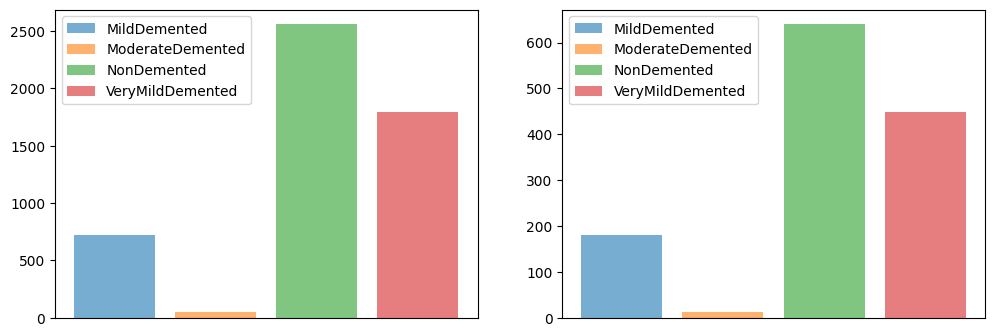

In [ ]:
sample_image_files = []
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, set_type in enumerate(['train', 'test']):
  for class_dir in CLASSES:
    images = list_images(os.path.join(DATASET_DIR, set_type, class_dir))
    ax[i].bar(class_dir, len(images), label=class_dir, alpha=0.6)

    if set_type == 'train':
      print(f'{class_dir} images: {len(images)}')
      for _ in range(3):
          sample_image_files.append(random.choice(images))

  ax[i].legend()
  ax[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


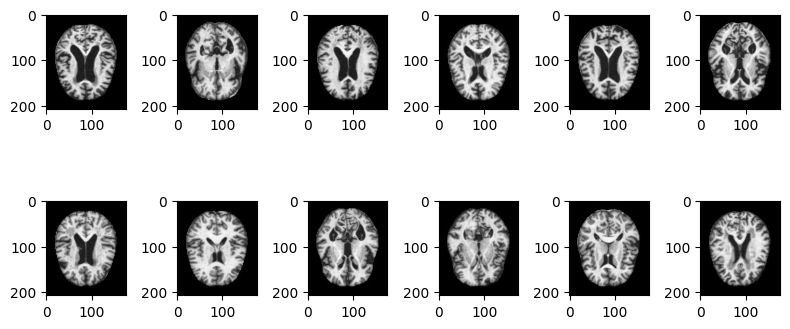

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(sample_image_files) // 2, figsize=(8, 4))
for i, image_path in enumerate(sample_image_files):
    image = Image.open(image_path)
    ax.flat[i].imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

## Model Training

### Utility functions

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].set_title('Epochs vs Loss and Validation Loss')
    ax[0].plot(history.history['loss'], label='loss', color='r')
    ax[0].set_xlabel('Epochs')

    ax[1].set_title('Epochs vs Accuracy and Validation Accuracy')
    ax[1].plot(history.history['accuracy'], label='accuracy', color='b')
    ax[1].set_xlabel('Epochs')

    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].set_ylabel('Loss')

    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_ylabel('Loss')

    ax[0].legend()
    ax[0].grid(True)
    ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax[1].legend()
    ax[1].grid(True)
    ax[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    fig.tight_layout()
    plt.show()

def confusion_matrix(y_pred, y):
    cm = tf.math.confusion_matrix(tf.argmax(y_pred, axis=1), tf.argmax(y, axis=1))
    # plt.figure(figsize=(8, 6))
    sns.heatmap(cm.numpy(), cmap="crest", linewidth=.5, annot=False)
    # add labels with confusion matrix values
    for i in range(len(cm.numpy())):
        for j in range(len(cm.numpy())):
            plt.text(j+0.5, i+0.5, cm.numpy()[i, j], ha='center', va='center', color='black')

### Base Line Model
- A simple model with an architecture that combines two convolutional layers for feature extraction from images and dense layers for classification.
- The use of softmax in the output layer makes it suitable for multi-class classification tasks.
- Normalization techniques such as batch normalization and dropout layers are added to prevent overfitting.
- Training vs. Validation Loss: The training loss decreases significantly over epochs. However, the validation loss decreases initially but then fluctuates and generally increases, suggesting that the model is not performing as wela.l on the validation set.
- Training vs. Validation Accuracy: The training accuracy is excellent, but the validation accuracy is quite volatile and does not show consistent improvement.
- Test Accuracy: The model achieves a test accuracy of approximately 67.34%, which is significantly lower than the training accuracy observed in the graph. This discrepancy suggests that the model may not be generalizing well to new data.

In [ ]:
def create_base_line_model(preprocessing_layers, opt='rmsprop'):
  model = models.Sequential([
    # Input
    layers.InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    # add the pre-processing layers
    * preprocessing_layers,
    # Convolutional
    layers.Conv2D(64, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    # Output
    layers.Dense(N_CLASSES, activation='softmax')
  ])

  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
backend.clear_session()
base_model = create_base_line_model(preprocessing_layers=[], opt=keras.optimizers.Adam(0.000125))
#base_model.summary()

Epoch 1/20
161/161 [==============================] - 17s 63ms/step - loss: 3.1070 - accuracy: 0.5536 - val_loss: 1.2236 - val_accuracy: 0.5196
Epoch 2/20
161/161 [==============================] - 7s 43ms/step - loss: 0.7322 - accuracy: 0.6684 - val_loss: 0.8941 - val_accuracy: 0.6072
Epoch 3/20
161/161 [==============================] - 8s 46ms/step - loss: 0.5251 - accuracy: 0.7743 - val_loss: 0.9480 - val_accuracy: 0.5931
Epoch 4/20
161/161 [==============================] - 8s 49ms/step - loss: 0.3347 - accuracy: 0.8614 - val_loss: 0.9611 - val_accuracy: 0.6088
Epoch 5/20
161/161 [==============================] - 10s 58ms/step - loss: 0.2354 - accuracy: 0.9026 - val_loss: 0.9107 - val_accuracy: 0.6526
Epoch 6/20
161/161 [==============================] - 9s 51ms/step - loss: 0.1677 - accuracy: 0.9318 - val_loss: 0.9359 - val_accuracy: 0.6557
Epoch 7/20
161/161 [==============================] - 7s 43ms/step - loss: 0.1456 - accuracy: 0.9414 - val_loss: 1.0290 - val_accuracy: 0.67

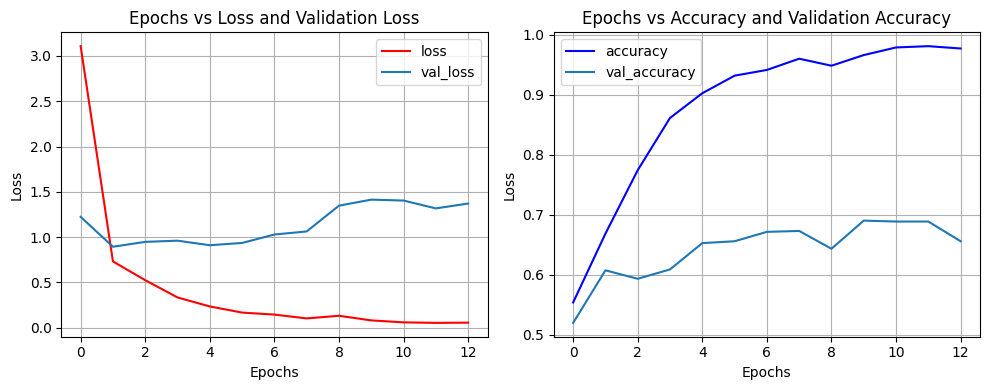

In [ ]:
history = base_model.fit(train_dataset, epochs=20, validation_data=val_dataset, batch_size=16,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                  restore_best_weights = True)])
plot_history(history)

In [ ]:
test_loss, test_accuracy = base_model.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 1s 20ms/step - loss: 1.3976 - accuracy: 0.6734
Test accuracy: 0.6734374761581421


### Data Augmentation
- The data augmentation strategy employs two types of transformations: RandomContrast and RandomTranslation. The RandomContrast can help the model become more robust to variations in image brightness and contrast. The RandomTranslation aids the model in learning to recognize objects regardless of their slight positional changes within the image frame.
- Several augmentation techniques were tested but ultimately not included in the final sequence: RandomRotation, RandomZoom, and RandomFlip. These layers were excluded because they did not contribute to performance improvement.
- The baseline model was trained again with the augmented dataset. The training vs. validation loss and accuracy improved, and the test accuracy improved from 67.34% to 69.06%.

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomContrast([0.1, 0.2], seed=RANDOM_STATE),
    #layers.RandomRotation([5, 7], seed=RANDOM_STATE),
    layers.RandomTranslation(0.04, 0.04, seed=RANDOM_STATE),
    #layers.RandomZoom(0.1, 0.1, seed=RANDOM_STATE
    #layers.RandomFlip('horizontal', seed=RANDOM_STATE),
])

def augment_image(image, label):
    aug_image = data_augmentation(image, training=True)
    if np.array_equal(aug_image, image):
        return None, None
    return aug_image, label

In [ ]:
augmented_dataset = train_dataset.map(augment_image)
augmented_train_dataset = train_dataset.concatenate(augmented_dataset)

Epoch 1/20
322/322 [==============================] - 22s 63ms/step - loss: 2.2920 - accuracy: 0.5292 - val_loss: 0.9529 - val_accuracy: 0.5618
Epoch 2/20
322/322 [==============================] - 24s 73ms/step - loss: 0.9276 - accuracy: 0.5452 - val_loss: 1.0026 - val_accuracy: 0.5837
Epoch 3/20
322/322 [==============================] - 21s 66ms/step - loss: 0.8632 - accuracy: 0.5716 - val_loss: 0.9029 - val_accuracy: 0.5853
Epoch 4/20
322/322 [==============================] - 19s 58ms/step - loss: 0.8269 - accuracy: 0.5925 - val_loss: 1.2453 - val_accuracy: 0.5524
Epoch 5/20
322/322 [==============================] - 19s 58ms/step - loss: 0.7606 - accuracy: 0.6246 - val_loss: 1.1066 - val_accuracy: 0.5806
Epoch 6/20
322/322 [==============================] - 22s 68ms/step - loss: 0.7106 - accuracy: 0.6562 - val_loss: 0.9231 - val_accuracy: 0.6182
Epoch 7/20
322/322 [==============================] - 19s 58ms/step - loss: 0.6897 - accuracy: 0.6686 - val_loss: 1.1369 - val_accuracy:

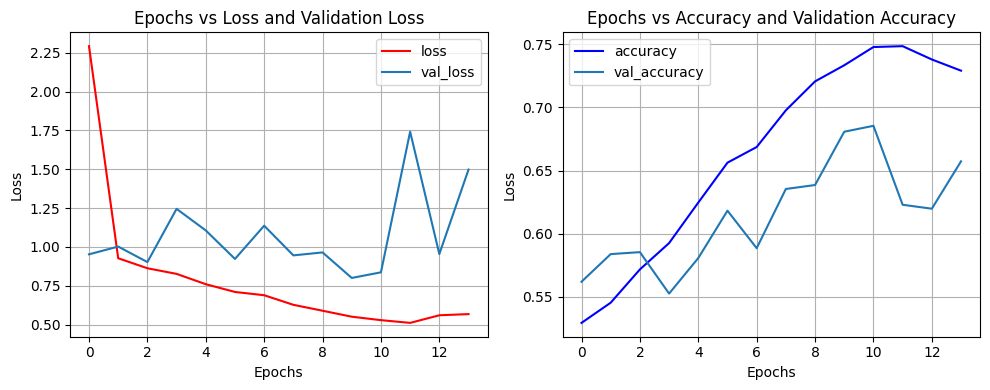

In [ ]:
backend.clear_session()
base_model_aug = create_base_line_model(preprocessing_layers=[], opt=keras.optimizers.Adam(0.000125))
history = base_model_aug.fit(augmented_train_dataset, epochs=20, validation_data=val_dataset, batch_size=16,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                  restore_best_weights = True)])
plot_history(history)

In [ ]:
test_loss, test_accuracy = base_model_aug.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 0s 19ms/step - loss: 0.8461 - accuracy: 0.6906
Test accuracy: 0.690625011920929


### Model 1
- The model is composed of three convolutional blocks, each having more layers and greater capacity for feature extraction than the baseline model.
- The model also incorporates the same normalization techniques previously used in the baseline model. The classification layers are the same as those in the baseline model.
- The classification layers is the same as the base line model.
- The model was training on the augmented dataset with accuracy of 68.12%
- The confusion matrix shows the skewness towards high correct predictions for the 'NonDemented' class and low correct predictions for the other classes, due to class imbalance in the dataset.
 - High Accuracy for the 'NonDemented' Class
 - Difficulty with the 'VeryMildDemented' Class
 - Confusion between 'MildDemented' and 'ModerateDemented' Classes
 - Low Instances of Correct Predictions for the 'ModerateDemented' Class.


In [ ]:
def create_model_1(preprocessing_layers, opt='rmsprop'):
  model = models.Sequential([
    # Input
    layers.InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    # add the pre-processing layers
    * preprocessing_layers,
    # Convolutional
    layers.Conv2D(64, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    # Output
    layers.Dense(N_CLASSES, activation='softmax')
  ])

  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Epoch 1/20
322/322 [==============================] - 25s 65ms/step - loss: 1.4259 - accuracy: 0.5529 - val_loss: 0.9088 - val_accuracy: 0.5853
Epoch 2/20
322/322 [==============================] - 23s 71ms/step - loss: 0.7949 - accuracy: 0.6297 - val_loss: 0.7840 - val_accuracy: 0.6322
Epoch 3/20
322/322 [==============================] - 21s 66ms/step - loss: 0.6886 - accuracy: 0.6839 - val_loss: 0.9247 - val_accuracy: 0.6385
Epoch 4/20
322/322 [==============================] - 21s 64ms/step - loss: 0.5825 - accuracy: 0.7440 - val_loss: 0.8173 - val_accuracy: 0.6651
Epoch 5/20
322/322 [==============================] - 21s 65ms/step - loss: 0.4790 - accuracy: 0.7910 - val_loss: 0.8482 - val_accuracy: 0.6510
Epoch 6/20
322/322 [==============================] - 21s 66ms/step - loss: 0.4053 - accuracy: 0.8325 - val_loss: 0.8771 - val_accuracy: 0.6604
Epoch 7/20
322/322 [==============================] - 21s 66ms/step - loss: 0.3469 - accuracy: 0.8531 - val_loss: 1.0152 - val_accuracy:

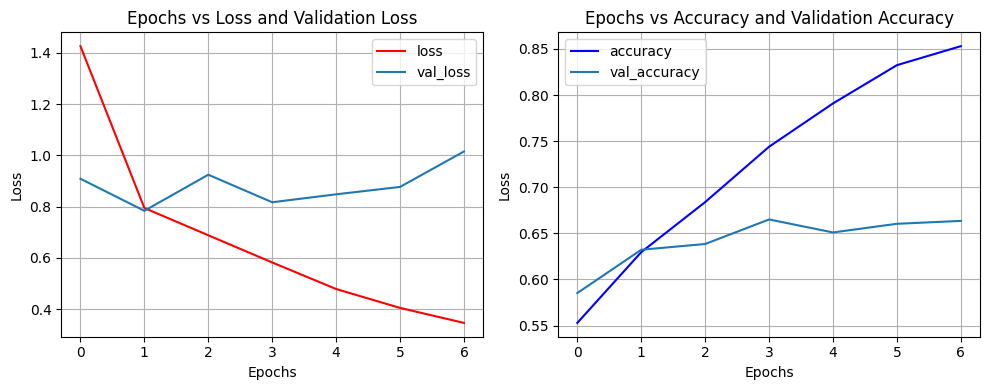

In [ ]:
backend.clear_session()
preprocessing = keras.layers.Rescaling(1./255)
model_1 = create_model_1(preprocessing_layers=[], opt=keras.optimizers.Adam(0.000125))
history = model_1.fit(augmented_train_dataset, epochs=20, validation_data=val_dataset, batch_size=16,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                  restore_best_weights = True)])
plot_history(history)

In [ ]:
test_loss, test_accuracy = model_1.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 1s 20ms/step - loss: 0.8055 - accuracy: 0.6812
Test accuracy: 0.6812499761581421


In [ ]:
X_test_list = []
y_test_list = []
for X_batch, y_batch in test_dataset:
  X_test_list.append(X_batch.numpy())
  y_test_list.append(y_batch.numpy())
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

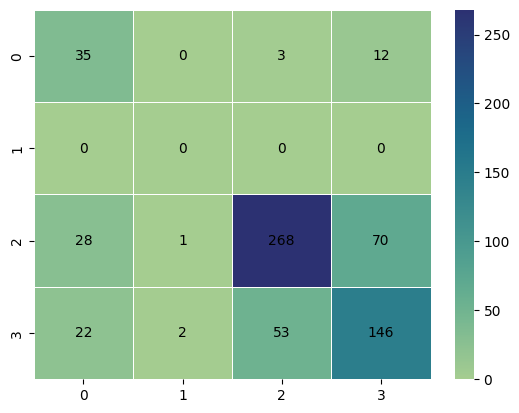

In [ ]:
y_pred = model_1.predict(X_test, verbose=0)
confusion_matrix(y_pred, y_test)

In [ ]:
print(CLASSES)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### Model 2
- The model is trained on the augmented dataset.
- The model is composed of four convolutional blocks, having one more layers and even more capacity for feature extraction than the model 1.
- The model's classifier includes a substantial number of neurons (512) in the first dense layer, followed by a dropout layer, then a smaller dense layer (128 neurons). This design aims to prevent overfitting while allowing the network to learn a complex hierarchy of features.
- The validation loss (blue line) does not show a steady decrease. It decreases initially but then starts to fluctuate.
- The validation accuracy (orange line) increases at a slower rate and begins to plateau much earlier than the training accuracy. Notably, there is a significant gap between training accuracy and validation accuracy.
- While the model has learned to fit the training data with a high degree of accuracy (73.12%), its ability to generalize to new data is less effective.
- The confusion matrix still struggles to predict the 'ModerateDemented' class. The class imbalance could be causing this.

In [ ]:
def create_model_2(preprocessing_layers, opt='rmsprops'):
  model = models.Sequential([
    # Input
    layers.InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    # add the pre-processing layers
    * preprocessing_layers,
    # Convolutional
    layers.Conv2D(64, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # Output
    layers.Dense(N_CLASSES, activation='softmax')
  ])

  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Epoch 1/20
322/322 [==============================] - 27s 70ms/step - loss: 1.3988 - accuracy: 0.4630 - val_loss: 0.9577 - val_accuracy: 0.5477
Epoch 2/20
322/322 [==============================] - 21s 66ms/step - loss: 1.0471 - accuracy: 0.5290 - val_loss: 1.1368 - val_accuracy: 0.5227
Epoch 3/20
322/322 [==============================] - 21s 66ms/step - loss: 0.9576 - accuracy: 0.5593 - val_loss: 1.2093 - val_accuracy: 0.5399
Epoch 4/20
322/322 [==============================] - 22s 68ms/step - loss: 0.8736 - accuracy: 0.5986 - val_loss: 0.9682 - val_accuracy: 0.5947
Epoch 5/20
322/322 [==============================] - 23s 71ms/step - loss: 0.7779 - accuracy: 0.6436 - val_loss: 0.9571 - val_accuracy: 0.5837
Epoch 6/20
322/322 [==============================] - 21s 64ms/step - loss: 0.6878 - accuracy: 0.6933 - val_loss: 1.0247 - val_accuracy: 0.5211
Epoch 7/20
322/322 [==============================] - 22s 68ms/step - loss: 0.6553 - accuracy: 0.7028 - val_loss: 0.9952 - val_accuracy:

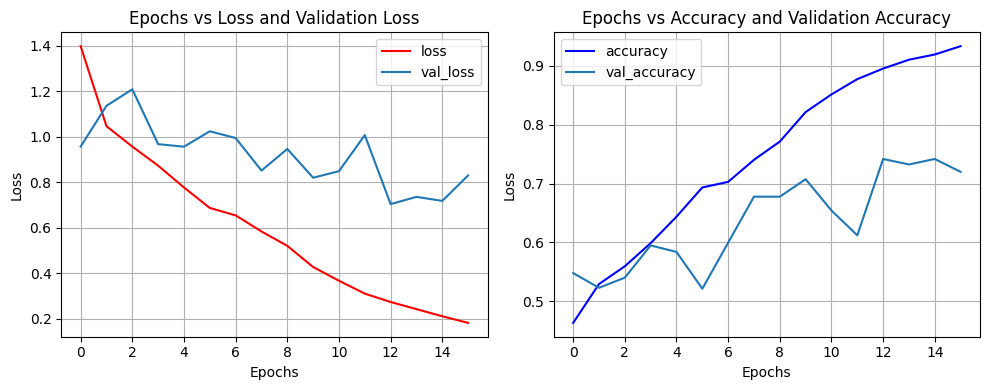

In [ ]:
backend.clear_session()
model_2 = create_model_2(preprocessing_layers=[], opt=keras.optimizers.Adam(0.000125))
history = model_2.fit(augmented_train_dataset, epochs=20, validation_data=val_dataset, batch_size=16,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                  restore_best_weights = True)])
plot_history(history)

In [ ]:
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 1s 19ms/step - loss: 0.7014 - accuracy: 0.7312
Test accuracy: 0.731249988079071


In [ ]:
X_test_list = []
y_test_list = []
for X_batch, y_batch in test_dataset:
  X_test_list.append(X_batch.numpy())
  y_test_list.append(y_batch.numpy())
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

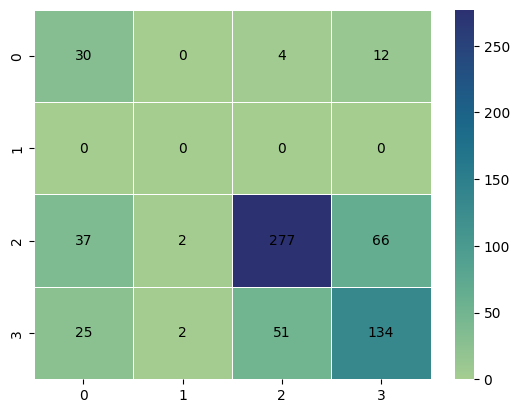

In [ ]:
y_pred = model_1.predict(X_test, verbose=0)
confusion_matrix(y_pred, y_test)

In [ ]:
print(CLASSES)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### Model 3
- This model implements an strategy that trains one model with grouped small classes and then using transfer learning to fine-tune a second model for the final classification of all classes. This approach can improve the model's performance on smaller classes by initially addressing the imbalance at a broader level and then fine-tuning.
- The dataset of **'two-classed'** is created that combine smaller classes into one single 'Demeneted' class.
- The model with grouped classes has the same architecture as model 2, with only the last layer modified to perform binary classification.
- Once the grouped trained model (base_model_3) is prepared, the first two convolutional block (layers 1-9) are frozen, and the remaining layers are marked as trainable.
- The model, model_3b, is created for multi-class classification using transfer learning by integrating the layers of base_model_3 with the Functional API.
- The training loss for model 3 decreases consistently and remains lower than the validation loss, which is also decreasing, indicating better generalization than model 2.
- The validation accuracy also increases, though there is some fluctuation; nonetheless, it maintains a general upward trend, indicating improvements in generalization compared to model 2. The test accuracy of model-3 is higher at approximately 77.19%.
- he confusion matrix shows improvements over Model 2:
 - The number of false negatives for Class 2 has decreased, and the number of true positives for Class 3 has increased.
 - The number of instances misclassified as Class 2 and Class 3 from Class 0 has also decreased. Class 1 now has true positives, whereas Model 2 was unable to identify any instances.

In [ ]:
DATASET_2CLASS_DIR = 'dataset/two_classes'

# create a new training directory where classes 'VeryMildDemented', 'MildDemented', 'ModerateDemented' are merged into one class 'Demented'
import shutil
for class_dir in CLASSES:
  for set_type in ['train', 'test']:
    src_dir = os.path.join(DATASET_DIR, set_type, class_dir)
    new_train_dir = os.path.join(DATASET_2CLASS_DIR, set_type, 'Demented' if class_dir != 'NonDemented' else class_dir)
    print(src_dir, '->', new_train_dir)

    os.makedirs(new_train_dir, exist_ok=True)
    images = list_images(os.path.join(DATASET_DIR, set_type, class_dir))
    for img_path in images:
        img_name = img_path.split('/')[-1]
        shutil.copy(img_path, os.path.join(new_train_dir, img_name))

dataset/Alzheimer_s Dataset/train/MildDemented -> dataset/two_classes/train/Demented
dataset/Alzheimer_s Dataset/test/MildDemented -> dataset/two_classes/test/Demented
dataset/Alzheimer_s Dataset/train/ModerateDemented -> dataset/two_classes/train/Demented
dataset/Alzheimer_s Dataset/test/ModerateDemented -> dataset/two_classes/test/Demented
dataset/Alzheimer_s Dataset/train/NonDemented -> dataset/two_classes/train/NonDemented
dataset/Alzheimer_s Dataset/test/NonDemented -> dataset/two_classes/test/NonDemented
dataset/Alzheimer_s Dataset/train/VeryMildDemented -> dataset/two_classes/train/Demented
dataset/Alzheimer_s Dataset/test/VeryMildDemented -> dataset/two_classes/test/Demented


In [ ]:
datasets = []
for subset in ['train', 'test']:
    image_dataset = keras.utils.image_dataset_from_directory(os.path.join(DATASET_2CLASS_DIR, subset),
                        labels='inferred', label_mode='binary', color_mode='grayscale',
                        batch_size=32, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), shuffle=True, seed=RANDOM_STATE,
                        crop_to_aspect_ratio=False)
    datasets.append(image_dataset)

train2_dataset, val2_dataset = datasets

Found 5121 files belonging to 2 classes.
Found 1098 files belonging to 2 classes.


In [ ]:
def model_3a(preprocessing_layers, opt='rmsprop'):
  model = models.Sequential([
    # Input
    layers.InputLayer(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    # add the pre-processing layers
    * preprocessing_layers,
    # Convolutional
    layers.Conv2D(64, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.BatchNormalization(),
    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    # Output
    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer = opt,
                loss = keras.losses.BinaryCrossentropy(), # from_logits=True
                metrics = ['accuracy'])
  return model

In [ ]:
backend.clear_session()
base_model_3 = model_3a(preprocessing_layers=[], opt=keras.optimizers.Adam(0.000125)) # 0.0000125, 0.00005

In [ ]:
history = base_model_3.fit(train2_dataset, epochs=25, validation_data=val2_dataset, batch_size=16, # 16, 24
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                  restore_best_weights = True)])

Epoch 1/25
161/161 [==============================] - 13s 60ms/step - loss: 0.6176 - accuracy: 0.7194 - val_loss: 0.5436 - val_accuracy: 0.6985
Epoch 2/25
161/161 [==============================] - 9s 58ms/step - loss: 0.3483 - accuracy: 0.8500 - val_loss: 0.6782 - val_accuracy: 0.6548
Epoch 3/25
161/161 [==============================] - 9s 56ms/step - loss: 0.1219 - accuracy: 0.9559 - val_loss: 0.5232 - val_accuracy: 0.7842
Epoch 4/25
161/161 [==============================] - 10s 58ms/step - loss: 0.0651 - accuracy: 0.9785 - val_loss: 0.5223 - val_accuracy: 0.8106
Epoch 5/25
161/161 [==============================] - 10s 59ms/step - loss: 0.0397 - accuracy: 0.9881 - val_loss: 0.6420 - val_accuracy: 0.7714
Epoch 6/25
161/161 [==============================] - 9s 54ms/step - loss: 0.0284 - accuracy: 0.9916 - val_loss: 0.5431 - val_accuracy: 0.7760
Epoch 7/25
161/161 [==============================] - 9s 58ms/step - loss: 0.0258 - accuracy: 0.9928 - val_loss: 0.5091 - val_accuracy: 0.7

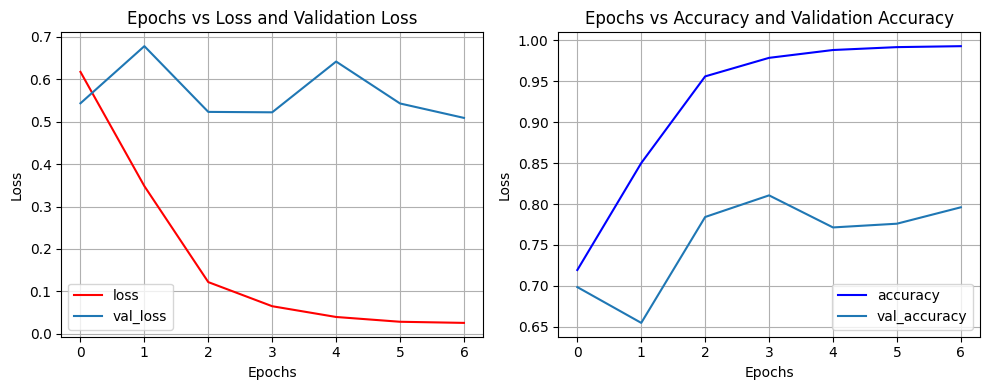

In [ ]:
plot_history(history)

In [ ]:
for layer in base_model_3.layers[:13]: # 6, 9, 13
    layer.trainable = False
for layer in base_model_3.layers[13:-1]: # 6, 9, 13
    layer.trainable = True
base_model_3.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 173, 205, 64)      1088      N          
                                                                            
 max_pooling2d (MaxPooling2  (None, 86, 102, 64)       0         N          
 D)                                                                         
                                                                            
 batch_normalization (Batch  (None, 86, 102, 64)       256       N          
 Normalization)                                                             
                                                                            
 conv2d_1 (Conv2D)           (None, 83, 99, 128)       131200    N          
                                                                            
 max_pooling2d_1 (MaxPoolin  (None, 41, 49, 128)       0

In [ ]:
# create a new model based on base_model_3 last N-1 layers
backend.clear_session()
model_3b = models.Sequential(base_model_3.layers[:-1])
model_3b.add(layers.Dense(N_CLASSES, name='output', activation='softmax'))

model_3b.compile(optimizer = keras.optimizers.Adam(0.000005), # 0.000005, 0.0000125 0.00001
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

history = model_3b.fit(augmented_train_dataset, epochs=30, validation_data=val_dataset, batch_size=24,
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,
                                                                    restore_best_weights = True)])

Epoch 1/30
322/322 [==============================] - 20s 48ms/step - loss: 1.4895 - accuracy: 0.4733 - val_loss: 1.0828 - val_accuracy: 0.6150
Epoch 2/30
322/322 [==============================] - 15s 45ms/step - loss: 1.3044 - accuracy: 0.5308 - val_loss: 1.0413 - val_accuracy: 0.6291
Epoch 3/30
322/322 [==============================] - 15s 45ms/step - loss: 1.1704 - accuracy: 0.5809 - val_loss: 0.9982 - val_accuracy: 0.6510
Epoch 4/30
322/322 [==============================] - 15s 46ms/step - loss: 1.0717 - accuracy: 0.6176 - val_loss: 0.9019 - val_accuracy: 0.6792
Epoch 5/30
322/322 [==============================] - 15s 45ms/step - loss: 1.0261 - accuracy: 0.6358 - val_loss: 0.9224 - val_accuracy: 0.6792
Epoch 6/30
322/322 [==============================] - 15s 45ms/step - loss: 0.9594 - accuracy: 0.6561 - val_loss: 0.9147 - val_accuracy: 0.6729
Epoch 7/30
322/322 [==============================] - 15s 45ms/step - loss: 0.8975 - accuracy: 0.6798 - val_loss: 0.8835 - val_accuracy:

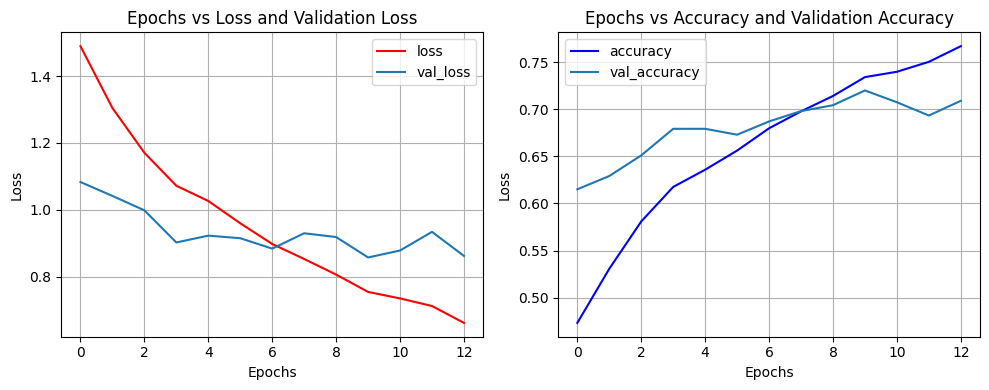

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_accuracy = model_3b.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 0s 18ms/step - loss: 0.8069 - accuracy: 0.7453
Test accuracy: 0.745312511920929


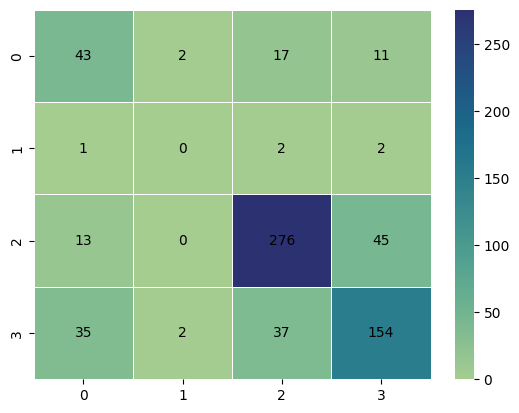

In [ ]:
y_pred = model_3b.predict(X_test, verbose=0)
confusion_matrix(y_pred, y_test)